<a href="https://colab.research.google.com/github/AlexLefte/Alex/blob/main/LITS_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


This challenge involves developing an automatic segmentation algorithm to segment liver lesions in contrast­-enhanced abdominal CT scans. For this specific task I have considered performing a multiclass segmentation using **U-Net**. 

The main reason for picking this architecture is that this kind of convolutional network is quite fast in segmentation of images. It was actually developed for **biomedical image segmentation**.

# Data import & preprocessing


In [ ]:
!pip install segmentation-models-3D

In [ ]:
%tensorflow_version 2.x  

import os
import csv
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
from keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/MyDrive/LITS Challenge/Training Batch 2/'  # Saving our training set's path, so we don't need to work with such long strings
test_path = '/content/gdrive/MyDrive/LITS Challenge/Training Batch 1/'   # The same with our testing set's path 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Getting familiar with our dataset**

In [ ]:
# Just to check what is our data like
# Let's take for example 'volume-125', and its segmantation: 'segmentation-125'

img = nib.load(train_path + 'volume-40.nii').get_fdata() 
print(img.shape) 
# print(img.max())  # Checking what is the maximum value, so we can scale out data
img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
# print(img.max())  # Now we can see the maximum value in our tensor is 1.0 (float type)

img_segm = nib.load(train_path + 'segmentation-40.nii').get_fdata() 
img_segm = img_segm.astype(np.uint8)  # Converting values from float type to int type (here we should only have integer values)
# print(np.unique(img_segm))  # Here we can see there are the 3 specified classes: 0 -> liver, 1 -> tumor, 2 -> everything else
# Which is also what we expected from the beginning
print(img_segm.shape)


(512, 512, 122)
(512, 512, 122)


**Let's display these 2 images, so we can notice the way data was segmented before**

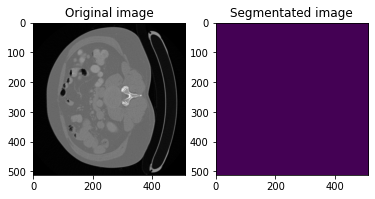

In [ ]:
# Always generate a random image number
n = random.randint(0, img.shape[2])

# Let's plot some images
plt.figure(1)
plt.subplot(121)
plt.imshow(img[:,:,n], cmap='gray')
plt.title('Original image')
plt.subplot(122)
plt.imshow(img_segm[:,:,n])
plt.title('Segmentated image')
plt.show()

# Although I could barely see some relevant data (most of the images were only made of "Everything else" pixels),
# I could find some images to help me understand the way this training set is segmentated 

**Proccessing the entire set**

In [ ]:
# Now we want to proccess the entire data set (both the training and the testing one),
# so what we want to is:
# 1. Going through each '.nii' file
# 2. Scaling it
# 3. Making sure the segmentated image does contain enough useful data (there are not only "Everything else" pixels) - Just for the training set
# 4. Saving the relevant data

img_list = sorted(glob.glob(train_path + "volume*"))  # We sorted it so that originals will match the segmentated images
img_segm_list = sorted(glob.glob(train_path + "segmentation*"))
# print(len(img_list), len(img_segm_list))  # Just to lengths of these lists match
# print(img_list)
# print(img_segm_list)

testing_list = sorted(glob.glob(test_path + "volume*"))
testing_segm_list = sorted(glob.glob(test_path + "segmentation*"))
# print(len(testing_list), len(testing_segm_list))

#  Selecting our training data
for i in range(len(img_list)):
  tmp = nib.load(img_list[i]).get_fdata()
  tmp = scaler.fit_transform(tmp.reshape(-1, tmp.shape[-1])).reshape(tmp.shape)
  
  tmp_segm = nib.load(img_segm_list[i]).get_fdata() 
  tmp_segm = tmp_segm.astype(np.uint8)  # Converting values from float type to int type (here we should only have integer values)

  # Reshaping our data in 256 x 256 x 256 pixels. The main reason for doing so is
  # related to both proccessing time and phisical resources
  tmp=tmp[128:384, 128:384, 1:129]
  tmp_segm = tmp_segm[128:384, 128:384, 1:129]

  # Counting the number of unique elements for each class, so we can determine
  # whether the specific image contains enough relevant data
  val, counts = np.unique(tmp_segm, return_counts=True)

  if (counts[0] / counts.sum()) < 0.95:  # If 0's count for more than 95% of the mask => we won't save this file
  # Otherwise we will save it
      tmp_segm = to_categorical(tmp_segm, num_classes=3)
      np.save('/content/LITS_train/img/volume_'+str(i)+'.npy', tmp)
      np.save('/content/LITS_train/img_segm/segmentation_'+str(i)+'.npy', tmp_segm)


In [ ]:
# Selecting our testing data
# For the reasons mentioned above, I decided to pick just a few CT-s for testing
# Otherwise instead of this list we would have used our "testing_list"
index_list = [1, 4, 15, 20, 25]
for i in index_list:
  tmp = nib.load(testing_list[i]).get_fdata()
  tmp = scaler.fit_transform(tmp.reshape(-1, tmp.shape[-1])).reshape(tmp.shape)
  
  tmp_segm = nib.load(testing_segm_list[i]).get_fdata() 
  tmp_segm = tmp_segm.astype(np.uint8)  # Converting values from float type to int type (here we should only have integer values)

  tmp=tmp[128:384, 128:384, 1:129]
  tmp_segm = tmp_segm[128:384, 128:384, 1:129]

  tmp_segm = to_categorical(tmp_segm, num_classes=3)
  
  np.save('/content/LITS_test/img_test/volume_'+str(i)+'.npy', tmp)
  np.save('/content/LITS_test/img_segm_test/segmentation_'+str(i)+'.npy', tmp_segm)

# Creating our data generator


In [ ]:
def images_list(img_direct, img_list):
  images = []
  for image_name in img_list:
    image = np.load(img_direct+image_name)
    images.append(image)
  images = np.dstack(images)
  return images


def imageLoader(img_direct, img_list, segm_direct, segm_list, batch_size):
    l = len(img_list)
    while True:
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < l:
            limit = min(batch_end, l)  # We want our limit not to get past our actual length 
          
            X = images_list(img_direct, img_list[batch_start:limit])
            Y = images_list(segm_direct, segm_list[batch_start:limit])
            yield (X,Y)      

            batch_start += batch_size   
            batch_end += batch_size


# Testing the data generator

In [ ]:
#Test the generator

train_img_dir = "/content/LITS_train/img/"
train_segm_dir = "/content/LITS_train/img_segm/"
train_img_list = sorted(os.listdir(train_img_dir))[1:]
train_segm_list = sorted(os.listdir(train_segm_dir))[1:]

batch_size = 2

test_img_dir = "/content/LITS_test/img/"
test_segm_dir = "/content/LITS_test/img_segm/"

test_img_list = sorted(os.listdir(train_img_dir))[1:]
test_segm_list = sorted(os.listdir(train_segm_dir))[1:]

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_segm_dir, train_segm_list, batch_size)
val_img_datagen = imageLoader(test_img_dir, test_img_list, test_segm_dir, test_segm_list, batch_size)


# Creating our 3D unet model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model


# Loss, metrics and optimizer for training

In [ ]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25  # Defining weights
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Fitting the model

In [ ]:
batch_size = 2

steps_per_epoch = len(train_img_list)//batch_size
test_steps_per_epoch = len(test_img_list)//batch_size

model = simple_unet_model(IMG_HEIGHT=256, 
                          IMG_WIDTH=256,
                          IMG_DEPTH=256, 
                          IMG_CHANNELS=1,
                          num_classes=3)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

model_1=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=test_steps_per_epoch
          )

model.save('/content/Model/lits.hdf5')

# Plotting the training and validation IoU and loss for each epoch

In [ ]:
loss = model_1.model_1['loss']
val_loss = model_1.model_1['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_1.model_1['accuracy']
val_acc = model_1.model_1['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loading the model and predict


In [ ]:
from keras.models import load_model
from keras.metrics import MeanIoU


my_model = load_model('/content/lits.hdf5', compile=False)

test_img_dir = "/content/LITS_test/img/"
test_segm_dir = "/content/LITS_test/img_segm/"

test_img_list = os.listdir(train_img_dir)
test_segm_list = os.listdir(train_segm_dir)

batch_size = 2
test_img_datagen = imageLoader(test_img_dir, test_img_list, 
                                test_segm_dir, test_segm_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# Plotting a prediction

In [ ]:
#Try images: 
img_num = 15

test_img = np.load("/content/LITS_test/img/"+str(img_num)+".npy")

test_mask = np.load("/content/LITS_test/img_segm/"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=2)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=2)[0,:,:]

#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

n_slice = 20
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

# Conclusions:



1.   Although I was not able to figure the project out until the very end, I found it very interesting and useful for my development. I must admit I had never tried this type of network architecture before.
2.   In order to improve the results of this type of algorithm I could have considered using all the CT-s provided for training (although U-Net is known to handle well even smaller data sets). The reasons I could not act so, was mostly because of the preproccessing and traing time, but also because of the physical memory.

